# Estimativa preços de venda do dataset Boston_housing

Um dos problemas clássicos de machine learning é a previsão dos preços das casas de Boston apresentado no final da década de 1970.

Existe uma competição no Kaggle que utiliza este dataset:
https://www.kaggle.com/c/boston-housing

O objetivo desse notebook é fazer a previsão dos preços das casas utilizando uma rede neural com uma camada escondida de 40 neurônios.


## Importação dos pacotes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.autograd import Variable

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Leitura do Dataset

Leitura do Dataset já normalizado: [boston_housing.ipynb](boston_housing.ipynb)
- **Atenção**: se houver erro em não achar o arquivo, executar o notebook boston_housing.ipynb

In [2]:
datain = np.load('../data/boston_housing_normalize.npz')

x, y = datain['Xtra'], datain['ytra']

In [3]:
n_samples, n_attributes = x.shape
print('n_samples:', n_samples)
print('n_attributes:', n_attributes)

n_samples: 506
n_attributes: 13


### Conversão para Tensor

In [4]:
x_train = torch.FloatTensor(x)
y_train = torch.FloatTensor(y)

## Rede, uma camada escondida de 40 neurônios

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(n_attributes, 40)
        self.ativ1  = nn.ReLU()
        self.layer2 = nn.Linear(40, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.ativ1(x)
        x = self.layer2(x)
        return x

model = Model()
if use_gpu:
    model.cuda()
model

Model (
  (layer1): Linear (13 -> 40)
  (ativ1): ReLU ()
  (layer2): Linear (40 -> 1)
)

## Parâmetros do otimizador

A escolha dos parâmetros para o treinamento é crítica. A escolha do learning rate,
do método de ótimização, do tamanho do mini-batch, do número de camadas, do número de neurônios em
cada camada, são todas críticas para o sucesso do estimador.

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, nesterov=True)
savebest = ptt.ModelCheckpoint('../../models/bostonhousing',reset=True, verbose=True)

trainer = ptt.DeepNetTrainer(
        model =         model,
        criterion =     criterion,
        optimizer =     optimizer,
        callbacks =     [savebest,ptt.PrintCallback()]
        )

## Treinamento

In [11]:
trainer.fit(60, x_train, y_train, valid_split=0.2, shuffle=True, batch_size=10)

Start training for 60 epochs
  1:   0.0s   T: 468.83251   V: 182.88720 best
  2:   0.0s   T: 94.29165   V: 20.17867 best
  3:   0.0s   T: 30.35625   V: 12.71947 best
  4:   0.0s   T: 23.26583   V: 12.56687 best
  5:   0.0s   T: 20.99705   V: 12.18597 best
  6:   0.0s   T: 19.55620   V: 12.07727 best
  7:   0.0s   T: 18.50999   V: 11.63718 best
  8:   0.0s   T: 17.31703   V: 11.31055 best
  9:   0.0s   T: 16.59785   V: 10.51864 best
 10:   0.0s   T: 15.79993   V: 10.58900 
 11:   0.0s   T: 15.15902   V: 10.69535 
 12:   0.0s   T: 14.79031   V: 9.57824 best
 13:   0.0s   T: 14.45834   V: 9.52772 best
 14:   0.0s   T: 13.86659   V: 9.26318 best
 15:   0.0s   T: 13.75825   V: 9.49959 
 16:   0.0s   T: 13.21375   V: 8.99207 best
 17:   0.0s   T: 13.00113   V: 9.04405 
 18:   0.0s   T: 12.69768   V: 8.64405 best
 19:   0.0s   T: 12.40066   V: 8.37456 best
 20:   0.0s   T: 12.22684   V: 8.26789 best
 21:   0.0s   T: 11.98909   V: 8.70873 
 22:   0.0s   T: 11.81154   V: 8.45671 
 23:   0.0s   

## Avaliação

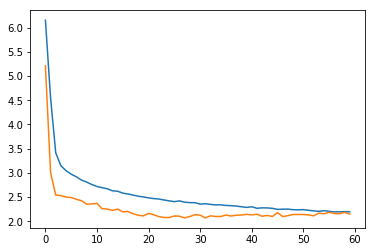

In [12]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, np.log(train_loss),
         epochs, np.log(valid_loss))

In [13]:
ptt.load_trainer_state('../../models/bostonhousing',trainer.model, trainer.metrics )

In [14]:
trainer.evaluate(x_train,y_train)

evaluate: 50/50 ok


{'loss': 0.019197035005571662}

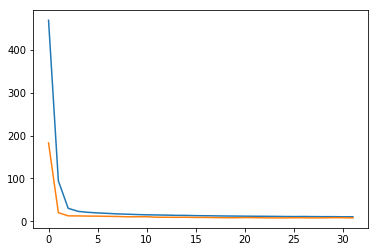

In [15]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss,
         epochs, valid_loss)

In [16]:
print('MSE:',valid_loss[-1])
print('RMSE:', np.sqrt(valid_loss[-1]))

MSE: 7.9272105528576535
RMSE: 2.81553024364


# Exercícios

- Troque os hyperparâmetros para verificar se você consegue obter valores melhores. A forma de
  escolha e alteração de parâmetros é algo que se aprende com a experiência. Procure fazer
  sintonias finas, variando apenas um ou poucos parâmetros de cada vez.
  
  Parâmetros que podem ser trocados:
  - learning rate
  - n. de camadas
  - n. de neurônios
  - troca de função de ativação
  - método de otimizador do gradiente descendente
